# FIT5202 Assignment 2: Rain in Australia: Predict rain tomorrow in Australia

# Isobel Rowe, 30042585

### Import libraries

In [1]:
# Sets the display to 90% of the window's max width - helps for displaying dataframes
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
import pyspark.sql.functions as F
from pyspark.sql.functions import col, sum
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

## A. Creating Spark Session and Loading the Data

### Step 01: Import Spark Session and initialize Spark

In [2]:
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# Create a new spark context running locally with 4 worker threads
if (sc is None):
    sc = SparkContext(master="local[4]", appName = "Assignment 2")
    
# Create spark session
spark = SparkSession(sparkContext = sc)


### Step 02: Load the dataset and print the schema and total number of entries

In [3]:
# Load data
weather_df = spark.read.csv("weatherAUS.csv", sep = ",", inferSchema = True, header = True)

# Print the total number of entries in the dataset
print("Total number of entries in the dataset: ", weather_df.count())


Total number of entries in the dataset:  142193


## B. Data Cleaning and Processing

### Step 03: Delete columns from the dataset


To delete any unwanted columns, we can simply define a list of columns that we want to delete. Then, we can use the `*` operator to pass the contents of your list as arguments to the pyspark method `drop()`.


In [4]:
# Create a list of columns to drop 
columns_to_drop = ["Date", "Location", "Evaporation", "Sunshine", "Cloud9am", "Cloud3pm", "Temp9am", "Temp3pm"]

# Use .drop() to remove unwanted columns
weather_df = weather_df.drop(*columns_to_drop)

# Check 
weather_df.printSchema()


root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



### Step 04: Print the number of missing data in each column.


Next, we want to print out the number of NA (or null) values in each column. In this file, the null values are just equal to str('NA'), which doesn't represent a null value. So, to fix this problem, I decided to first replace string null value with an actual null value via `.replace()` and `None`. 

Then, I displayed the null counts for each column using by summing the null values with `isNull()`.


In [5]:
# Replace NA string to null value
weather_df = weather_df.replace(str('NA'), None)

# Print out null values
weather_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in weather_df.columns)).show()


+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



### Step 05: Fill the missing data with average value and maximum occurrence value.

#### Numeric 

For the numeric columns, I decided to use the `Imputer()` transformer from pyspark. Because all of the numeric columns were stored as strings, I cast them to doubles to circumvent any problems as the input columns should be of DoubleType.

In [6]:
# Cast strings to doubles
cols = ['MaxTemp', 'MinTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm']
for col_name in cols:
    weather_df = weather_df.withColumn(col_name, col(col_name).cast('double'))

# Create imputer
imputer = Imputer(
inputCols=['MaxTemp', 'MinTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm'],
outputCols=['MaxTemp', 'MinTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm'])

# Apply imputer to dataframe
weather_df = imputer.fit(weather_df).transform(weather_df)

# Check the null values are removed
weather_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in weather_df.columns)).show()


+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|      0|      0|       0|       9330|            0|     10013|      3778|           0|           0|          0|          0|          0|          0|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



#### Categorical

The pyspark imputer does not support categorical features, so, to impute the categorical columns, I dropped the null values and found the most common value (or maximum frequency value) for each categorical column. Next, I used the most common value to fill the null values with the `.when()` and `.otherwise()` functions.


In [7]:
# Create loop through dataframe
for col_name in ['WindGustDir','WindDir9am', 'WindDir3pm', 'RainToday']:
    # Find the most common value
    common = weather_df.dropna().groupBy(col_name).agg(F.count("*")).orderBy('count(1)', ascending=False).first()[col_name]
    # Fill in the blanks with the common value
    weather_df = weather_df.withColumn(col_name, F.when(F.isnull(col_name), common).otherwise(weather_df[col_name]))
    
# Check the null values are removed
weather_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in weather_df.columns)).show()


+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|      0|      0|       0|          0|            0|         0|         0|           0|           0|          0|          0|          0|          0|        0|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



### Step 06: Data transformation

The tranformation of the numerical value columns to doubles was already completed in the previous step, so all that needs to be done is the string indexing. I did this by creating a StringIndexer for each categorical column, and then simply applying it to the dataframe via `.fit()` and `.transform()`. I also dropped the original columns, and checked the datatypes.


In [8]:
# Create string indexers for each categorical column
WindGustDirIndexer = StringIndexer(inputCol="WindGustDir", outputCol="WindGustDirIndex")
WindDir9amIndexer = StringIndexer(inputCol="WindDir9am", outputCol="WindDir9amIndex")
WindDir3pmIndexer = StringIndexer(inputCol="WindDir3pm", outputCol="WindDir3pmIndex")
RainTodayIndexer = StringIndexer(inputCol="RainToday", outputCol="RainTodayIndex")
RainTomorrowIndexer = StringIndexer(inputCol="RainTomorrow", outputCol="RainTomorrowIndex")

# Create a list of the indexers
indexers = [WindGustDirIndexer, WindDir9amIndexer, WindDir3pmIndexer, RainTodayIndexer, RainTomorrowIndexer]

# Apply to dataframe using loop
for indexer in indexers:
    weather_df = indexer.fit(weather_df).transform(weather_df)
    
# Drop original columns    
columns_to_drop = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
weather_df = weather_df.drop(*columns_to_drop)

# Check datatypes
weather_df.dtypes


[('MinTemp', 'double'),
 ('MaxTemp', 'double'),
 ('Rainfall', 'double'),
 ('WindGustSpeed', 'double'),
 ('WindSpeed9am', 'double'),
 ('WindSpeed3pm', 'double'),
 ('Humidity9am', 'double'),
 ('Humidity3pm', 'double'),
 ('Pressure9am', 'double'),
 ('Pressure3pm', 'double'),
 ('WindGustDirIndex', 'double'),
 ('WindDir9amIndex', 'double'),
 ('WindDir3pmIndex', 'double'),
 ('RainTodayIndex', 'double'),
 ('RainTomorrowIndex', 'double')]

### Step 07: Create the feature vector and divide the dataset

Next, `VectorAssembler()` is used to create the feature vector. I made sure to exclude the 'RainTomorrowIndex' column as this is our target variable.

I also divided the data into a training set and a testing set using `.randomSplit()` with 70% for training and 30% for testing, ready for the classification algorithms.


In [9]:
# Create vector assembler
assembler = VectorAssembler(
    inputCols=['MaxTemp', 'MinTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'WindGustDirIndex','WindDir9amIndex', 'WindDir3pmIndex', 'RainTodayIndex'],
    outputCol="features")

# Apply the vector assembler
output = assembler.transform(weather_df)

# Isolate the relevant variables
output = output.select("features","RainTomorrowIndex")

# Divide data into train sets and test sets
trainingData, testData = output.randomSplit([0.7, 0.3], seed = 2018)

# Display the sizes of the sets
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))


Training Dataset Count: 99626
Test Dataset Count: 42567


## C. Apply Machine Learning Algorithms

### Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph.


For each of the classification algorithms I followed the same approach:

First, I created the classifier and passed in the label column as "RainTomorrowIndex" and the features column as "features". Then, I trained the model with the training dataset, and tested with the test dataset. 

Finally, I used the `MulticlassClassificationEvaluator()` to check the accuracy of each model. Accuracy here is calculated with the number of correct predictions divided by the number of all predictions. Another alternative to this accuracy calculation is Area Under ROC, which is used for binary classfication via `BinaryClassificationEvaluator()`. It is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example. I used both of these accuracy measures.


#### Decision Tree

In [10]:
# Create the classfier
dt = DecisionTreeClassifier(labelCol="RainTomorrowIndex", featuresCol="features")
# Train
dtModel = dt.fit(trainingData)
# Test
dt_predictions = dtModel.transform(testData)

# Evaluate the accuracy of the classification technique
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrowIndex", predictionCol="prediction", metricName="accuracy")
dt_accuracy = accuracy_evaluator.evaluate(dt_predictions)

# Evaluate the area under roc
auroc_evaluator = BinaryClassificationEvaluator(labelCol="RainTomorrowIndex", metricName="areaUnderROC")
dt_auroc = auroc_evaluator.evaluate(dt_predictions)

# Display results
print("Accuracy: ", dt_accuracy)
print("Test Area Under ROC: " , dt_auroc)


Accuracy:  0.8339088965630653
Test Area Under ROC:  0.2935299963877992


#### Random Forest

In [11]:
# Create and fit classifier
rf = RandomForestClassifier(labelCol="RainTomorrowIndex", featuresCol="features", numTrees=10)
rfModel = rf.fit(trainingData)
rf_predictions = rfModel.transform(testData)

# Evaluate
rf_accuracy = accuracy_evaluator.evaluate(rf_predictions)
rf_auroc = auroc_evaluator.evaluate(rf_predictions)

# Display results
print("Accuracy: ", rf_accuracy)
print("Test Area Under ROC: " , rf_auroc)


Accuracy:  0.832405384452745
Test Area Under ROC:  0.820717557914375


#### Logistic Regression

In [12]:
# Create and fit classifier
lr = LogisticRegression(featuresCol = 'features', labelCol = 'RainTomorrowIndex', maxIter = 10)
lrModel = lr.fit(trainingData)
lr_predictions = lrModel.transform(testData)   

# Evaluate
lr_accuracy = accuracy_evaluator.evaluate(lr_predictions)
lr_auroc = auroc_evaluator.evaluate(lr_predictions)

# Display results
print("Accuracy: ", lr_accuracy)
print("Test Area Under ROC: " , lr_auroc)


Accuracy:  0.814997533300444
Test Area Under ROC:  0.8100937256235617


#### GBT Classifier

In [13]:
# Create and fit classifier
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'RainTomorrowIndex', maxIter = 10)
gbtModel = gbt.fit(trainingData)
gbt_predictions = gbtModel.transform(testData)   

# Evaluate
gbt_accuracy = accuracy_evaluator.evaluate(gbt_predictions)
gbt_auroc = auroc_evaluator.evaluate(gbt_predictions)

# Display results
print("Accuracy: ", gbt_accuracy)
print("Test Area Under ROC: " , gbt_auroc)


Accuracy:  0.839922945004346
Test Area Under ROC:  0.8542578257492897


#### Plot 

Finally, I made a bar chart to compare the accuracy of each classification type. As can be seen below, the decision tree classifier performed the best, with the random forest following closely behind. The logistic regression performed the worst of all, with an accuracy of 0.80. 

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 <a list of 10 Text yticklabel objects>)

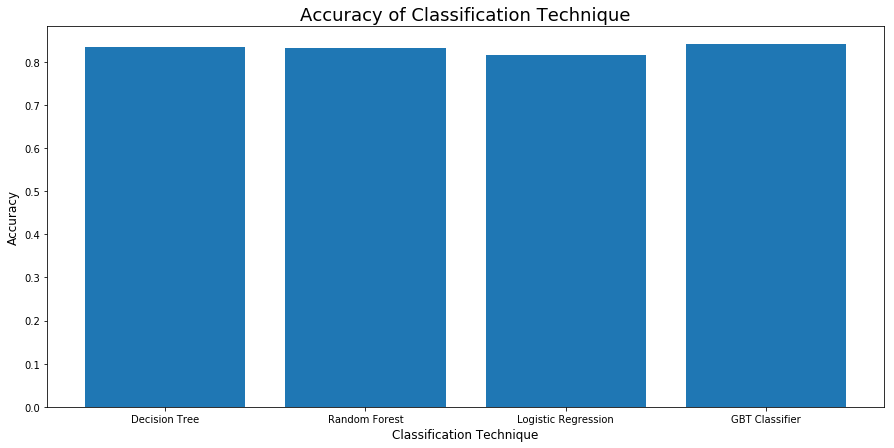

In [14]:
# Define inputs for plot
name = ["Decision Tree", "Random Forest", "Logistic Regression", "GBT Classifier"]
accuracy = [dt_accuracy, rf_accuracy, lr_accuracy, gbt_accuracy]

# Create plot
plt.figure(figsize=(15,7))
plt.bar(name, accuracy)

# Add labels
plt.title("Accuracy of Classification Technique", fontsize = 18)
plt.xlabel('Classification Technique', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)


### Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved?


Because we are using MultiClassMetrics for evaluating the output of a Binary classifier, I passed in `label=1` as an argument in precision and recall methods for binary classification.

However, I noticed that this work-around does not work for the F1 score. Luckily, the calculation is simple so I did each manually to ensure the correct result was achieved. The formulas used are as follows:

$Precision = (TP) / (TP + FP)$

$Recall = TP / (TP + FN)$

$F Score = 2* ((PI * R) / (P + R))$




#### Decision Tree


In [15]:
# Metrics
results = dt_predictions.select(['prediction', 'RainTomorrowIndex'])
predictionRDD = results.rdd
metrics = MulticlassMetrics(predictionRDD)

# Confusion Matrix
cm = metrics.confusionMatrix().toArray()
print("Confusion Matrix: \n", cm)

# Metrics with multiclassmetrics
print("\n--------------------------------- \nMulticlassMetrics Calculations: \n")
print("Precision: ", metrics.precision(label=1))
print("Recall: ", metrics.recall(label=1))
print("F1 Score: ", metrics.fMeasure())


# Manual calulations
# Accessing values in confusion matrix array 
tp = cm[1][1]
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]

# Precision
p = float(tp) / (tp + fp)
print("\n--------------------------------- \nManual Calculations: \n")
print("Precision: ", p)

# Recall
r = float(tp)/(tp + fn)
print("Recall: ", r)

# F1 Score
f1 = 2*((p*r) / (p + r))
print("F1 Score: ", f1)

Confusion Matrix: 
 [[32026.   985.]
 [ 6085.  3471.]]

--------------------------------- 
MulticlassMetrics Calculations: 

Precision:  0.7789497307001796
Recall:  0.3632272917538719
F1 Score:  0.8339088965630653

--------------------------------- 
Manual Calculations: 

Precision:  0.7789497307001796
Recall:  0.3632272917538719
F1 Score:  0.4954324864401941


#### Random Forest

In [16]:
# Metrics
results = rf_predictions.select(['prediction', 'RainTomorrowIndex'])
predictionRDD = results.rdd
metrics = MulticlassMetrics(predictionRDD)

# Confusion Matrix
cm = metrics.confusionMatrix().toArray()
print("Confusion Matrix: \n", cm)

# Metrics with multiclassmetrics
print("\n--------------------------------- \nMulticlassMetrics Calculations: \n")
print("Precision: ", metrics.precision(label=1))
print("Recall: ", metrics.recall(label=1))
print("F1 Score: ", metrics.fMeasure())


# Manual calulations
# Accessing values in confusion matrix array 
tp = cm[1][1]
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]

# Precision
p = float(tp) / (tp + fp)
print("\n--------------------------------- \nManual Calculations: \n")
print("Precision: ", p)

# Recall
r = float(tp)/(tp + fn)
print("Recall: ", r)

# F1 Score
f1 = 2*((p*r) / (p + r))
print("F1 Score: ", f1)

Confusion Matrix: 
 [[31919.  1092.]
 [ 6042.  3514.]]

--------------------------------- 
MulticlassMetrics Calculations: 

Precision:  0.7629179331306991
Recall:  0.3677270824612809
F1 Score:  0.832405384452745

--------------------------------- 
Manual Calculations: 

Precision:  0.7629179331306991
Recall:  0.3677270824612809
F1 Score:  0.49625759073577175


#### Logistic Regression

In [17]:
# Metrics
results = lr_predictions.select(['prediction', 'RainTomorrowIndex'])
predictionRDD = results.rdd
metrics = MulticlassMetrics(predictionRDD)

# Confusion Matrix
cm = metrics.confusionMatrix().toArray()
print("Confusion Matrix: \n", cm)

# Metrics with multiclassmetrics
print("\n--------------------------------- \nMulticlassMetrics Calculations: \n")
print("Precision: ", metrics.precision(label=1))
print("Recall: ", metrics.recall(label=1))
print("F1 Score: ", metrics.fMeasure())


# Manual calulations
# Accessing values in confusion matrix array 
tp = cm[1][1]
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]

# Precision
p = float(tp) / (tp + fp)
print("\n--------------------------------- \nManual Calculations: \n")
print("Precision: ", p)

# Recall
r = float(tp)/(tp + fn)
print("Recall: ", r)

# F1 Score
f1 = 2*((p*r) / (p + r))
print("F1 Score: ", f1)

Confusion Matrix: 
 [[30690.  2321.]
 [ 5554.  4002.]]

--------------------------------- 
MulticlassMetrics Calculations: 

Precision:  0.6329274078760082
Recall:  0.4187944746755965
F1 Score:  0.814997533300444

--------------------------------- 
Manual Calculations: 

Precision:  0.6329274078760082
Recall:  0.4187944746755965
F1 Score:  0.5040619686378235


#### GBT Classifier

In [18]:
# Metrics
results = gbt_predictions.select(['prediction', 'RainTomorrowIndex'])
predictionRDD = results.rdd
metrics = MulticlassMetrics(predictionRDD)

# Confusion Matrix
cm = metrics.confusionMatrix().toArray()
print("Confusion Matrix: \n", cm)

# Metrics with multiclassmetrics
print("\n--------------------------------- \nMulticlassMetrics Calculations: \n")
print("Precision: ", metrics.precision(label=1))
print("Recall: ", metrics.recall(label=1))
print("F1 Score: ", metrics.fMeasure())


# Manual calculations
# Accessing values in confusion matrix array 
tp = cm[1][1]
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]

# Precision
p = float(tp) / (tp + fp)
print("\n--------------------------------- \nManual Calculations: \n")
print("Precision: ", p)

# Recall
r = float(tp)/(tp + fn)
print("Recall: ", r)

# F1 Score
f1 = 2*((p*r) / (p + r))
print("F1 Score: ", f1)

Confusion Matrix: 
 [[31453.  1558.]
 [ 5256.  4300.]]

--------------------------------- 
MulticlassMetrics Calculations: 

Precision:  0.7340389211334927
Recall:  0.44997907074089577
F1 Score:  0.839922945004346

--------------------------------- 
Manual Calculations: 

Precision:  0.7340389211334927
Recall:  0.44997907074089577
F1 Score:  0.5579343454002854


#### How to improve accuracy of the predictions:


There are many options for improving the accuracy of these classifiers. 

***Feature selection*** is the process of finding the subset of attributes which best explain the relationship between independent variables and the target variable. May be based on prior domain knowledge or statistical evaluation such as p-value or correlation.


***Algorithm tuning*** is the process of finding the optimum value for each parameter to improve accuaracy of the model. For instance, in random forest classification, there are various parameters such as max_features, number_trees etc. Intuitive optimisation of these parameter values can result in better and more accurate models.


***Hyperparameter tuning*** is a common technique to optimise machine learning models based on hyperparameters, or configurations that are not learned during model training.  Tuning these configurations can help to avoid overfitting and dramatically improve model performance. In pySpark, tools such as CrossValidator and TrainValidationSplit are available to help with this.
